This notebook has been used to produce plots for my article on Distribution of the Order Flow in Python [(find it here)](https://medium.com/technological-singularity/distribution-of-the-order-flow-in-python-d7ba059dbf13)

In [363]:
# imports 
import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import scipy.stats


In [364]:
def pr_b_buys_given_n(state, n, mu, b):
    """
    Calculate the probability of observing a certain number of 'buys' given the state.

    Parameters:
    - state (str): The state of the system, either 'high' or 'low'.
    - n (int): The total number of trades.
    - mu (float): The probability of a 'buy' in the 'high' state.
    - b (int): The number of observed 'buys'.

    Returns:
    - float: The probability of observing the specified number of 'buys' given the state.
    """
    p = ((1 + mu) / 2) if state == 'high' else ((1 - mu) / 2)
    return (p**b) * (1 - p)**(n - b) * scipy.special.binom(n, b)

def compute_unconditional_prob(n, mu, b, delta):
    """
    Calculate the unconditional probability of observing a certain number of 'buys'.

    Parameters:
    - n (int): The total number of trades.
    - mu (float): The probability of a 'buy' in the 'high' state.
    - b (int): The number of observed 'buys'.
    - delta (float): The probability of being in the 'low' state.

    Returns:
    - float: The unconditional probability of observing the specified number of 'buys'.
    """
    p_n_high = pr_b_buys_given_n('high', n, mu, b)
    p_n_low = pr_b_buys_given_n('low', n, mu, b)

    return delta * p_n_low + (1 - delta) * p_n_high

def get_probabilities(n, delta):
    """
    Calculate unconditional probabilities for different scenarios of 'buys' given the number of trades and delta.

    Parameters:
    - n (int): The total number of trades.
    - delta (float): The probability of being in the 'low' state.

    Returns:
    - pandas.DataFrame: A DataFrame containing the unconditional probabilities for different scenarios.
    """
    p_0_list = []
    p_01_list = []
    p_05_list = []

    for b in range(0, n + 1):
        p_0 = compute_unconditional_prob(n=n, mu=0, b=b, delta=delta)
        p_0_list.append(p_0)

        p_01 = compute_unconditional_prob(n=n, mu=0.1, b=b, delta=delta)
        p_01_list.append(p_01)

        p_05 = compute_unconditional_prob(n=n, mu=0.5, b=b, delta=delta)
        p_05_list.append(p_05)

    df = pd.DataFrame({'Number of buys b': range(0, n+1),
                    'mu = 0': p_0_list,
                    'mu = 0.1': p_01_list,
                    'mu = 0.5': p_05_list})
    df = df.set_index('Number of buys b')

    return df

In [366]:
df_delta_02 = get_probabilities(n=50, delta=0.2)
df_delta_05 = get_probabilities(n=50, delta=0.5)
df_delta_09 = get_probabilities(n=50, delta=0.8)

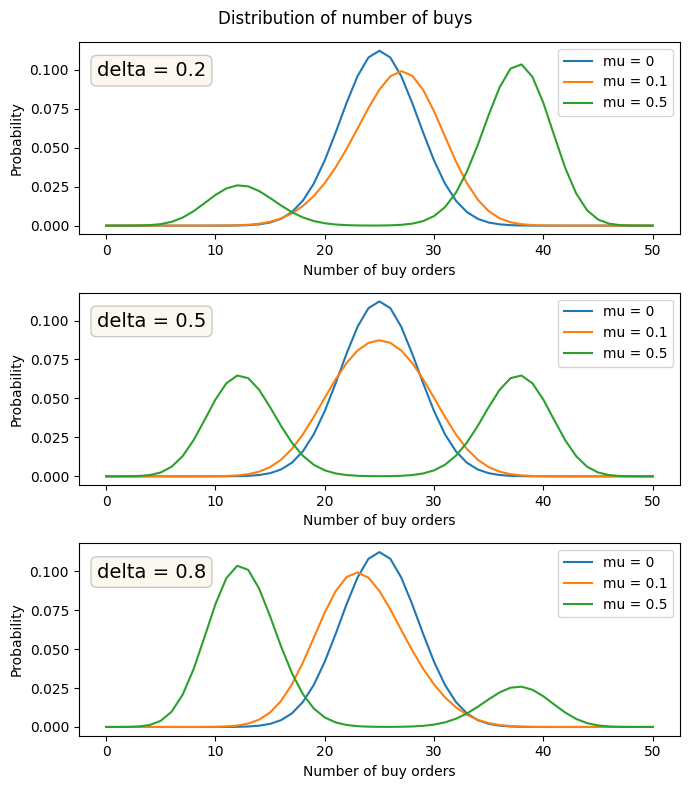

In [367]:
# plots
fig, axs = plt.subplots(3, 1, figsize=(7, 8))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
x_props = 0.03
y_props = 0.9

axs[0].plot(df_delta_02)
axs[0].legend(['mu = 0', 'mu = 0.1', 'mu = 0.5'])
axs[0].set_xlabel('Number of buy orders')
axs[0].set_ylabel('Probability')
axs[0].text(x_props, y_props, 'delta = 0.2', transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

axs[1].plot(df_delta_05)
axs[1].legend(['mu = 0', 'mu = 0.1', 'mu = 0.5'])
axs[1].set_xlabel('Number of buy orders')
axs[1].set_ylabel('Probability')
axs[1].text(x_props, y_props, 'delta = 0.5', transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

axs[2].plot(df_delta_09)
axs[2].legend(['mu = 0', 'mu = 0.1', 'mu = 0.5'])
axs[2].set_xlabel('Number of buy orders')
axs[2].set_ylabel('Probability')
axs[2].text(x_props, y_props, 'delta = 0.8', transform=axs[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.suptitle("Distribution of number of buys")

# Mostra l'immagine
plt.tight_layout()


plt.show()

Order flow as Poisson

In [368]:
def poisson_prob(alpha, delta, epsilon, mu, b, s):
    """
    Calculate the probability of observing a certain number of buys and sells in a Poisson process.

    Parameters:
    - alpha (float): Probability of infinite activity.
    - delta (float): Probability of being in the 'low' state.
    - epsilon (float): Intensity parameter for the Poisson process.
    - mu (float): Mean of the Poisson process.
    - b (int): Number of buys observed.
    - s (int): Number of sells observed.

    Returns:
    - float: The probability of observing the specified number of buys and sells.
    """
    prob_buy_not_inf = scipy.stats.poisson.pmf(k=b, mu=epsilon)
    prob_buy_inf_and_not_inf = scipy.stats.poisson.pmf(k=b, mu=epsilon + mu)

    prob_sell_not_inf = scipy.stats.poisson.pmf(k=s, mu=epsilon)
    prob_sell_inf_and_not_inf = scipy.stats.poisson.pmf(k=s, mu=epsilon + mu)

    return (1 - alpha) * prob_buy_not_inf * prob_sell_not_inf + (
        alpha) * ((delta * prob_buy_not_inf * prob_sell_inf_and_not_inf) + 
                  ((1 - delta) * prob_buy_inf_and_not_inf * prob_sell_not_inf))


def plot_lobes(alpha, delta, n, cmap):
    """
    Plot the joint probability density for buy and sell orders.

    Parameters:
    - alpha (float): Probability of infinite activity.
    - delta (float): Probability of being in the 'low' state.
    - n (int): The maximum number of buy and sell orders.
    - cmap (str or Colormap): The colormap to use for the plot.

    Returns:
    - None
    """
    X, Y = np.meshgrid(range(0, n + 1), range(0, n + 1))
    Z = poisson_prob(alpha=alpha, delta=delta, epsilon=10, mu=10, b=X, s=Y)
    text = f"alpha = {alpha}, delta = {delta} \nepsilon = 10, mu = 10"

    fig = plt.figure(figsize=(8, 5))

    plt.contour(X, Y, Z, cmap=cmap)
    plt.colorbar()
    plt.title('Joint probability density for buy and sell orders')
    plt.xlabel('Number of buy orders')
    plt.ylabel('Number of sell orders')
    plt.text(x=15, y=28, s=text, fontsize=12,
        verticalalignment='top', bbox=props)
    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(X.flatten(), Y.flatten(), Z.flatten(), cmap=cmap)
    ax.view_init(elev=30, azim=60)

    ax.set_xlabel('Number of buy orders')
    ax.set_ylabel('Number of sell orders')
    ax.set_zlabel('Probability')
    ax.set_title('Joint probability density for buy and sell orders', fontsize=16)
    ax.text(x=1, y=40, z=Z.max()*8.5, s=text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()



The greater alpha the more informed trades occurr.

The greater delta the more the informed agents are going to trande on the sell side.

So with delta = 0.5 we observe two lobes.

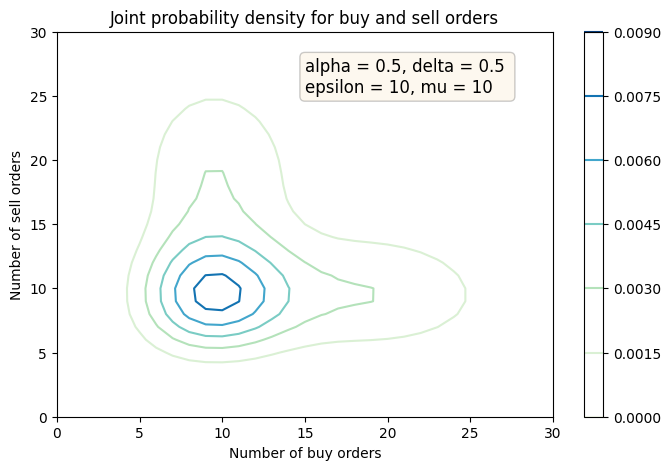

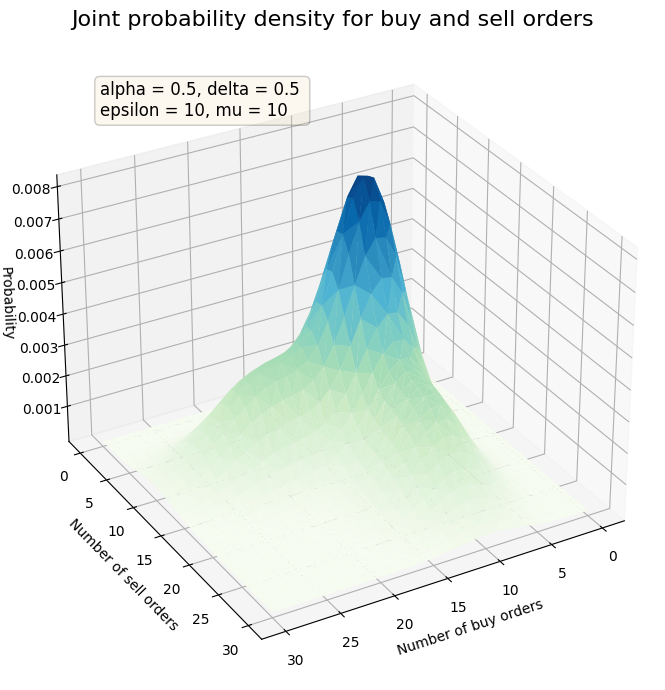

In [370]:
# Surface plot
n = 30

cmap = 'GnBu'

alpha = 0.5
delta = 0.5

plot_lobes(alpha, delta, n, cmap)

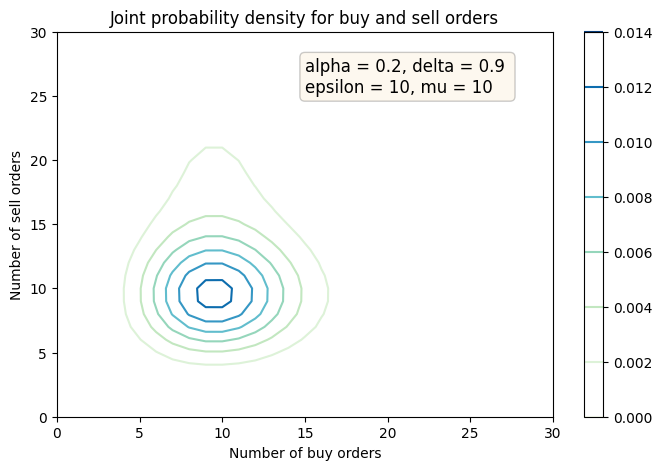

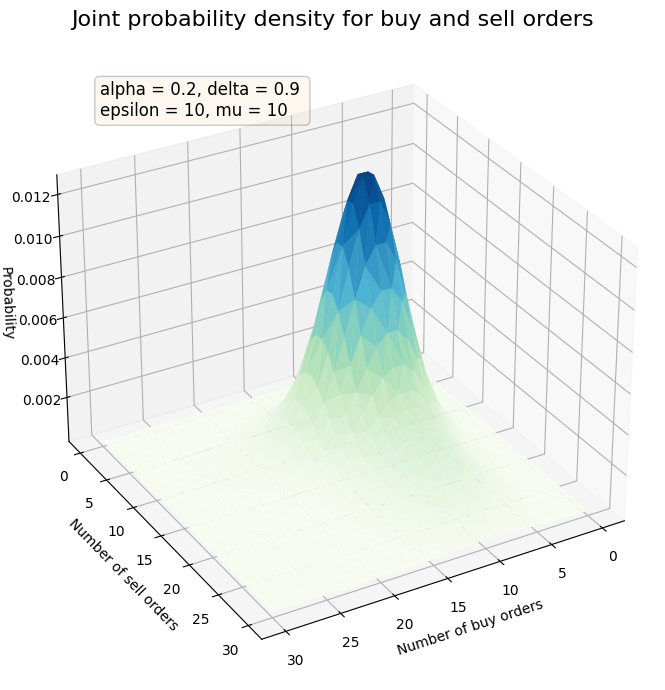

In [371]:
alpha = 0.2
delta = 0.9

plot_lobes(alpha, delta, n, cmap)

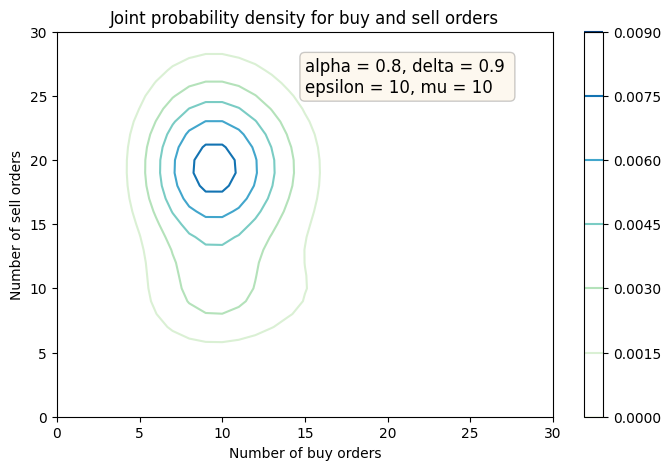

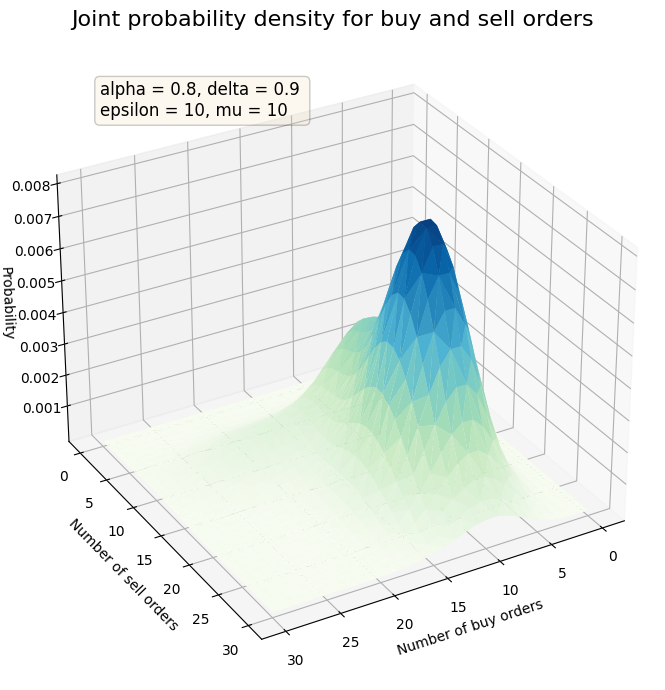

In [372]:
alpha = 0.8
delta = 0.9

plot_lobes(alpha, delta, n, cmap)

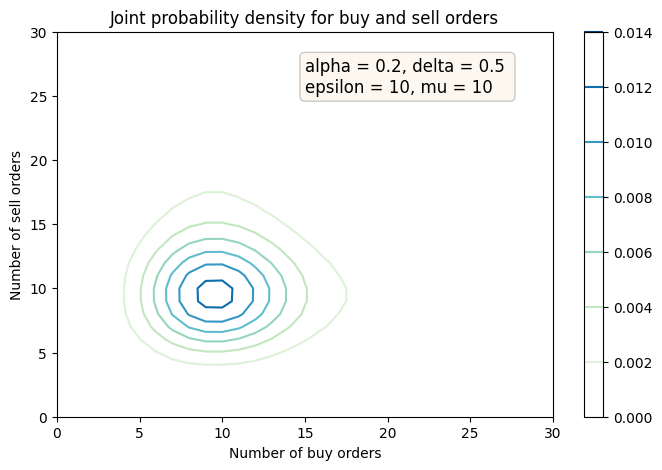

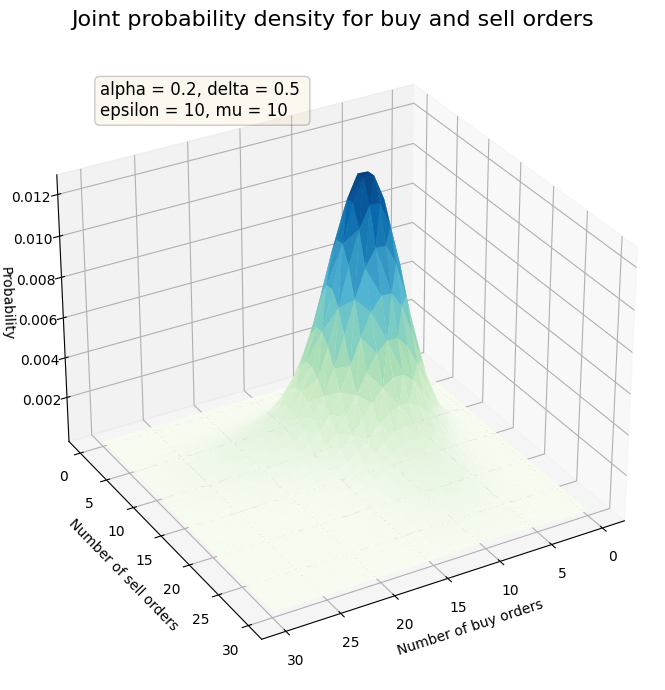

In [373]:
alpha = 0.2
delta = 0.5

plot_lobes(alpha, delta, n, cmap)

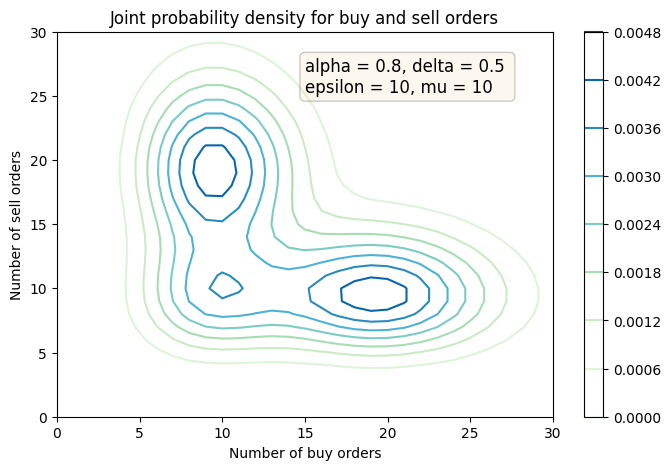

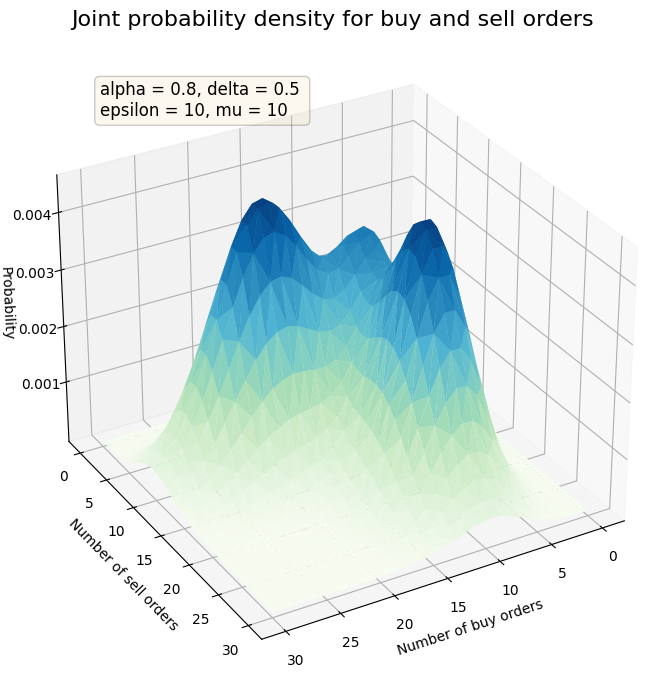

In [374]:
alpha = 0.8
delta = 0.5

plot_lobes(alpha, delta, n, cmap)